In [6]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities  import  WikipediaAPIWrapper,ArxivAPIWrapper

In [7]:
api_wwrp_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wwrp_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [8]:
arxiv.invoke("What is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from lab research to commercial products in the\npast decade as it plays an increasingly crucial role in data communication for\nnext-generation data centers and high performance computing1. Recently,\nprogr'

In [9]:
api_wwraper_wikipedia=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wwraper_wikipedia)
wiki.name

'wikipedia'

In [11]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [12]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [13]:
tavily.invoke("Provide me the recent AI news?")

[{'title': 'Artificial Intelligence News - ScienceDaily',
  'url': 'https://www.sciencedaily.com/news/computers_math/artificial_intelligence/',
  'content': '### Thursday, April 3, 2025\n\n### Thursday, March 27, 2025\n\n### Wednesday, March 26, 2025\n\n### Tuesday, March 25, 2025\n\n### Thursday, March 20, 2025\n\n### Wednesday, March 19, 2025\n\n### Tuesday, March 18, 2025\n\n### Monday, March 17, 2025\n\n### Thursday, March 6, 2025\n\n### Wednesday, March 5, 2025\n\n### Tuesday, March 4, 2025\n\n### Thursday, February 27, 2025\n\n### Wednesday, February 26, 2025\n\n### Tuesday, February 25, 2025\n\n### Friday, February 21, 2025\n\n### Thursday, February 20, 2025 [...] ![ScienceDaily](/images/sd-logo.png)\n\n# Artificial Intelligence News\n\n## Top Headlines\n\n## Latest Headlines\n\n## Earlier Headlines\n\n### Wednesday, May 7, 2025\n\n### Tuesday, May 6, 2025\n\n### Monday, May 5, 2025\n\n### Thursday, May 1, 2025\n\n### Wednesday, April 30, 2025\n\n### Friday, April 25, 2025\n\n##

In [14]:
## combine all these tools in the list
tools=[arxiv, wiki, tavily]

In [15]:
## Initialize the LLM Model
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

In [16]:
llm.invoke("What is AI")

AIMessage(content='\n<think>\nOkay, the user is asking, "What is AI?" Let me start by defining AI in simple terms. I should explain that AI stands for Artificial Intelligence. Then I need to mention the key areas it involves, like computer science, engineering, and mathematics. Maybe I should break down the core concepts: mimicking human cognitive functions, problem-solving, learning, and reasoning.\n\nWait, I should make sure to differentiate between general AI and narrow AI. Oh right, narrow AI is what we have now, like voice assistants. General AI is still theoretical. I should explain both to give a clear picture.\n\nApplications are important too. Listing examples like healthcare, finance, and gaming could help the user understand where AI is used. Also, mentioning machine learning and deep learning as subsets would be useful. I need to clarify that machine learning is a method of achieving AI, and deep learning is a part of that.\n\nDon\'t forget to touch on the goals of AI, such

In [17]:
llm_with_tools=llm.bind_tools(tools=tools)

In [18]:
## Execute this call
llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hzj8akdt7', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 247, 'prompt_tokens': 270, 'total_tokens': 517, 'completion_time': 0.577754242, 'prompt_time': 0.020037193, 'queue_time': 0.344796647, 'total_time': 0.597791435}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e6ef1ed4-4c6d-41cb-a3f8-6ce979b61257-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'hzj8akdt7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 270, 'output_tokens': 247, 'total_tokens': 517})

In [19]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human message or AI message
from typing import Annotated  ## labelling
from langgraph.graph.message import add_messages  ## Reducers in Langgraph

In [20]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [21]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

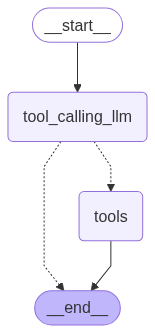

In [22]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edgess
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (9rneay473)
 Call ID: 9rneay473
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [24]:
messages=graph.invoke({"messages":"Hi My name is Krish"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Krish
================================== Ai Message ==================================

Hi Krish! Nice to meet you. How can I assist you today?


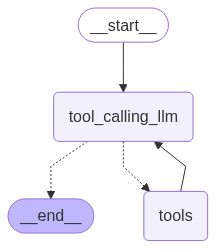

In [25]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edgess
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
messages=graph.invoke({"messages":"What is the recent AI news and then please tell me the recent research paper on quantum computing?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news and then please tell me the recent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8zjcmq6vy)
 Call ID: 8zjcmq6vy
  Args:
    query: recent AI news
  arxiv (wrf2dnbrc)
 Call ID: wrf2dnbrc
  Args:
    query: recent quantum computing research papers
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "**Date:** June 1, 2025  \n**Summary:** Ukraine reportedly used AI-enhanced drone swarms in a covert mission dubbed âOperation Spider Webâ to target a Russian bomber. The drones, said to cost as little as the price of an iPhone 16 Pro, represent a new phase